In [3]:
import os
import os.path as osp
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_files_in_dir(dir, absolute=True):
    if absolute:
        return [os.path.join(dir, f) for f in os.listdir(dir)]
    else:
        return [f for f in os.listdir(dir)]

def summarize_df(dir_reports):
    try:
        df = pd.concat([
            pd.read_csv(os.path.join(dir_reports, 'export_meterto_csv_report_ElectricityFacility_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1) / 3600000,
            pd.read_csv(os.path.join(dir_reports, 'export_variableto_csv_report_GeneratorProducedDCElectricEnergy_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1).sum(axis=1) / 3600000,
            pd.read_csv(os.path.join(dir_reports, 'export_variableto_csv_report_FacilityNetPurchasedElectricEnergy_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1) / 3600000,
        ], axis=1)
        df.columns = ['Consumed kWh', 'Generated kWh', 'Purchased kWh']
        df['Consumed PV kWh'] = np.minimum(df['Generated kWh'], df['Consumed kWh'])
        df['Exported PV kWh'] = np.minimum(df['Purchased kWh'], 0) * -1
    except:
        df = pd.concat([
            pd.read_csv(os.path.join(dir_reports, 'export_meterto_csv_report_ElectricityFacility_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1) / 3600000,
            pd.read_csv(os.path.join(dir_reports, 'export_variableto_csv_report_FacilityNetPurchasedElectricEnergy_ZoneTimestep.csv')).drop(['Zone Timestep'], axis=1) / 3600000,
        ], axis=1)
        df.columns = ['Consumed kWh', 'Purchased kWh']

    df.index = pd.date_range(start="2006-01-01",end="2007-1-1", freq='10min')[:-1]
    df['Month'] = pd.to_datetime(df.index).month
    df['day_of_year'] = pd.to_datetime(df.index).day_of_year
    df['Year'] = pd.to_datetime(df.index).year
    return df

def power_reduction_kpi(
    df_1, # Baseline
    df_2, # EF
    t_feat='Month'
):
    df_r = pd.DataFrame((df_1['Consumed kWh']-df_2['Consumed kWh']).values, index=df_1.index, columns=['Reduced kWh'])
    df = pd.concat([df_r, df_1[['Month', 'day_of_year', 'Year']]], axis=1)
    assert t_feat in ['day_of_year', 'Month', 'Year']
    ls_t, ls_reduced_kWh, ls_rebound_kWh, ls_reduced_kW, ls_increased_kW = [], [], [], [], []
    for i, df_t in df.groupby(t_feat):
        ls_t.append(df_t[t_feat].values[0])
        ls_reduced_kWh.append(df_t[df_t['Reduced kWh']>0]['Reduced kWh'].sum())
        ls_rebound_kWh.append(-df_t[df_t['Reduced kWh']<0]['Reduced kWh'].sum())
        ls_reduced_kW.append(df_t['Reduced kWh'].max()*6)
        ls_increased_kW.append(-df_t['Reduced kWh'].min()*6)

    df_kpi = pd.DataFrame({
        t_feat: ls_t,
        "Reduced kWh": ls_reduced_kWh,
        "Rebound kWh": ls_rebound_kWh,
        "Max kW Reduction": ls_reduced_kW,
        'Max kW Increase': ls_increased_kW
    })

    df_kpi = df_kpi.set_index(df_kpi[t_feat]).drop([t_feat], axis=1)
    return df_kpi
    # df_kpi[['Reduced kWh', 'Rebound kWh']].plot()


DIR_REPO = 'D:/GitHub/EnergyFlexibilityOntology'      # Desktop
DIR_REPO = 'G:/SDI/FY22_EF/EnergyFlexibilityOntology' # Z8
DIR_SIM = osp.join(DIR_REPO, 'example/case_study_1/EF_sim')
DIR_OUT = osp.join(DIR_SIM, 'output')


In [4]:
bldg_type = 'SmallOffice'
dir_baseline = osp.join(DIR_SIM, 'workflows_baseline')
ef_scenarios = [
    'baseline',
    'baseline+pv',
    'baseline+pv+ev',
    'baseline+ST_adjust',
    'baseline+pre_cond',
    'baseline+dr_light',
    'baseline+dr_mels',
    'baseline+dr_light_mels',
]

dict_all_results = {}
for ef_scenario in ef_scenarios:
    dir_scenario = osp.join(DIR_SIM, f'workflows_{bldg_type}_{ef_scenario}')
    for dir_clm in get_files_in_dir(dir_scenario):
        clm = dir_clm.split('-')[-1]
        dir_scn_clm_reports = osp.join(dir_clm, 'reports')
        df = summarize_df(dir_scn_clm_reports)
        dict_all_results[f"{ef_scenario}_{clm}"] = df
dict_all_results.keys()

dict_keys(['baseline_1A', 'baseline_2A', 'baseline_2B', 'baseline_3A', 'baseline_3B', 'baseline_3C', 'baseline_4A', 'baseline_4B', 'baseline_4C', 'baseline_5A', 'baseline_5B', 'baseline_6A', 'baseline_6B', 'baseline_7A', 'baseline_8A', 'baseline+pv_1A', 'baseline+pv_2A', 'baseline+pv_2B', 'baseline+pv_3A', 'baseline+pv_3B', 'baseline+pv_3C', 'baseline+pv_4A', 'baseline+pv_4B', 'baseline+pv_4C', 'baseline+pv_5A', 'baseline+pv_5B', 'baseline+pv_6A', 'baseline+pv_6B', 'baseline+pv_7A', 'baseline+pv_8A', 'baseline+pv+ev_1A', 'baseline+pv+ev_2A', 'baseline+pv+ev_2B', 'baseline+pv+ev_3A', 'baseline+pv+ev_3B', 'baseline+pv+ev_3C', 'baseline+pv+ev_4A', 'baseline+pv+ev_4B', 'baseline+pv+ev_4C', 'baseline+pv+ev_5A', 'baseline+pv+ev_5B', 'baseline+pv+ev_6A', 'baseline+pv+ev_6B', 'baseline+pv+ev_7A', 'baseline+pv+ev_8A', 'baseline+ST_adjust_1A', 'baseline+ST_adjust_2A', 'baseline+ST_adjust_2B', 'baseline+ST_adjust_3A', 'baseline+ST_adjust_3B', 'baseline+ST_adjust_3C', 'baseline+ST_adjust_4A', 'bas

In [5]:
clms = ['1A', '2A', '2B', '3A', '3B', '3C', '4A', '4B', '4C', '5A', '5B', '6A', '6B', '7A', '8A']
efs = ['ST_adjust', 'dr_light', 'dr_mels', 'dr_light_mels', 'pre_cond']

efs_map = {
    'ST_adjust': 'Setpoint Adjustment',
    'dr_light': 'Lighting DR',
    'dr_mels': 'MELs DR',
    'dr_light_mels': 'Lighting + MELs DR',
    'pre_cond': 'Pre-conditioning',
}

clm = '5B'
ef = 'dr_mels'
ef = 'dr_light_mels'

ls_df_kpis = []
for clm in clms:
    for ef in efs:
        df_1 = dict_all_results[f"baseline_{clm}"].iloc[:-144]
        df_2 = dict_all_results[f"baseline+{ef}_{clm}"].iloc[:-144]

        # f, ax = plt.subplots(1, 1, figsize=(20, 4))
        # df_1.iloc[-2000:]['Consumed kWh'].plot(ax=ax, label="Baseline")
        # df_2.iloc[-2000:]['Consumed kWh'].plot(ax=ax, label="DR Lighting")
        # plt.legend()
        df_reduction_kpi = power_reduction_kpi(df_1, df_2)
        df_reduction_kpi['Climate Zone'] = clm
        df_reduction_kpi['EF Operation'] = efs_map[ef]
        ls_df_kpis.append(df_reduction_kpi)
df_all_kpis = pd.concat(ls_df_kpis).reset_index()
df_all_kpis

,Month,Reduced kWh,Rebound kWh,Max kW Reduction,Max kW Increase,Climate Zone,EF Operation
0,1,86.383781,49.172505,3.271831,1.577052,1A,Setpoint Adjustment
1,2,85.605435,50.628414,3.299220,1.573673,1A,Setpoint Adjustment
2,3,97.984868,56.547440,3.445956,1.588665,1A,Setpoint Adjustment
3,4,92.859275,54.738889,3.458109,1.622996,1A,Setpoint Adjustment
4,5,111.961177,66.940321,3.558052,1.662336,1A,Setpoint Adjustment
...,...,...,...,...,...,...,...
895,8,88.246433,57.612551,2.368308,1.383607,8A,Pre-conditioning
896,9,44.560321,22.214737,2.309171,1.000691,8A,Pre-conditioning
897,10,71.685413,38.034669,2.799441,2.452860,8A,Pre-conditioning
898,11,11.548696,16.312846,1.978772,2.300428,8A,Pre-conditioning


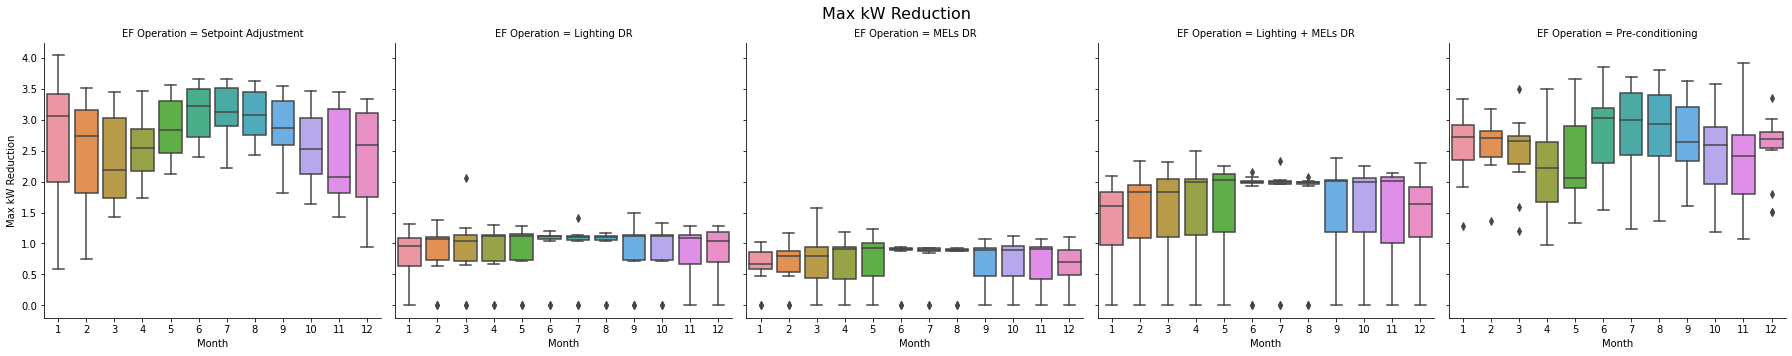

In [6]:
g = sns.catplot(
    data=df_all_kpis, x='Month', y='Max kW Reduction',
    col='EF Operation', col_wrap=5,
    kind='box'
)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Max kW Reduction', size=16)
g.savefig(osp.join(DIR_OUT, 'Max_kW_Reduction.png'), bbox_inches='tight')

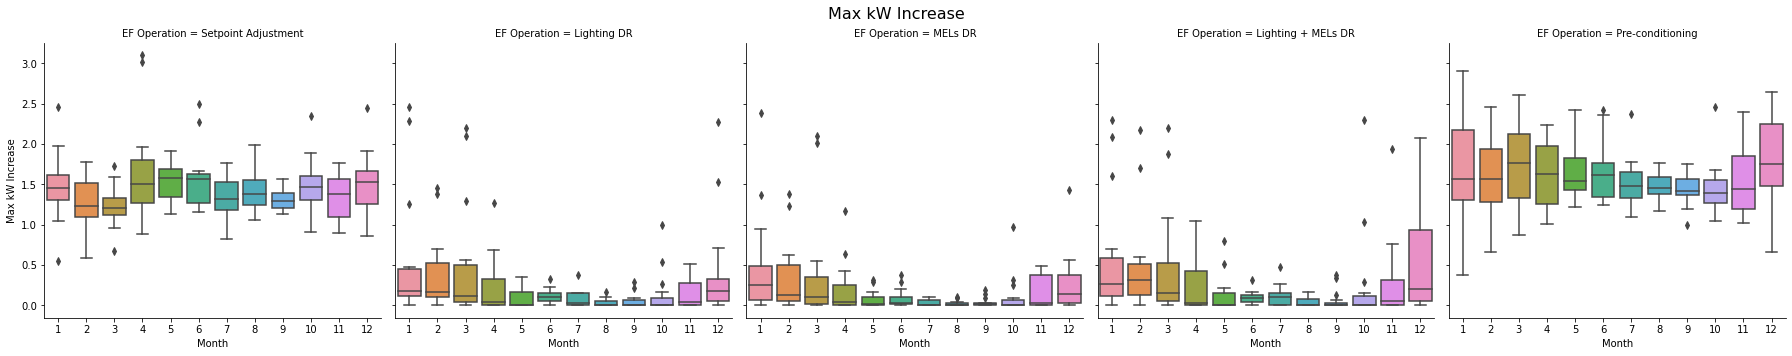

In [7]:
g = sns.catplot(
    data=df_all_kpis, x='Month', y='Max kW Increase',
    col='EF Operation', col_wrap=5,
    kind='box'
)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Max kW Increase', size=16)
g.savefig(osp.join(DIR_OUT, 'Max_kW_Increase.png'), bbox_inches='tight')

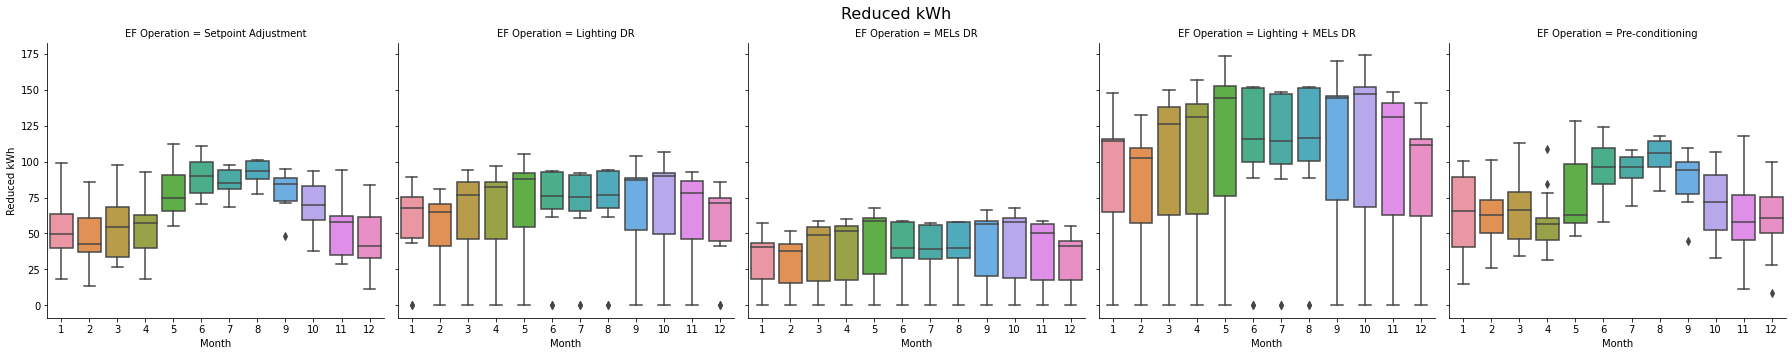

In [76]:
g = sns.catplot(
    data=df_all_kpis, x='Month', y='Reduced kWh',
    col='EF Operation', col_wrap=5,
    kind='box'
)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Reduced kWh', size=16)
g.savefig(osp.join(DIR_OUT, 'Reduced_kWh.png'), bbox_inches='tight')

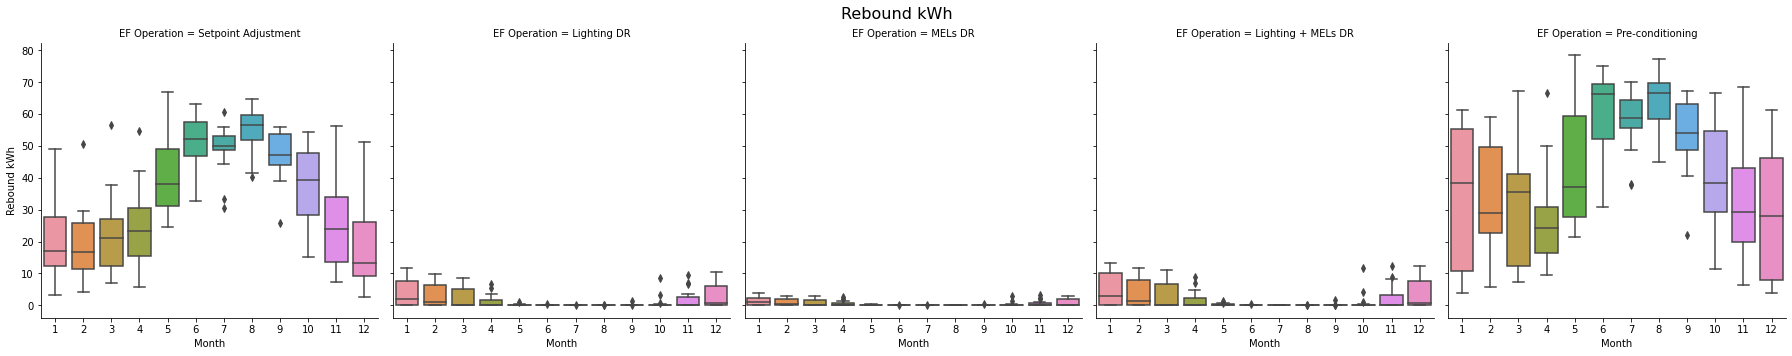

In [75]:
g = sns.catplot(
    data=df_all_kpis, x='Month', y='Rebound kWh',
    col='EF Operation', col_wrap=5,
    kind='box'
)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Rebound kWh', size=16)
g.savefig(osp.join(DIR_OUT, 'Rebound_kWh.png'), bbox_inches='tight')

<AxesSubplot:xlabel='Month', ylabel='Reduced kWh'>

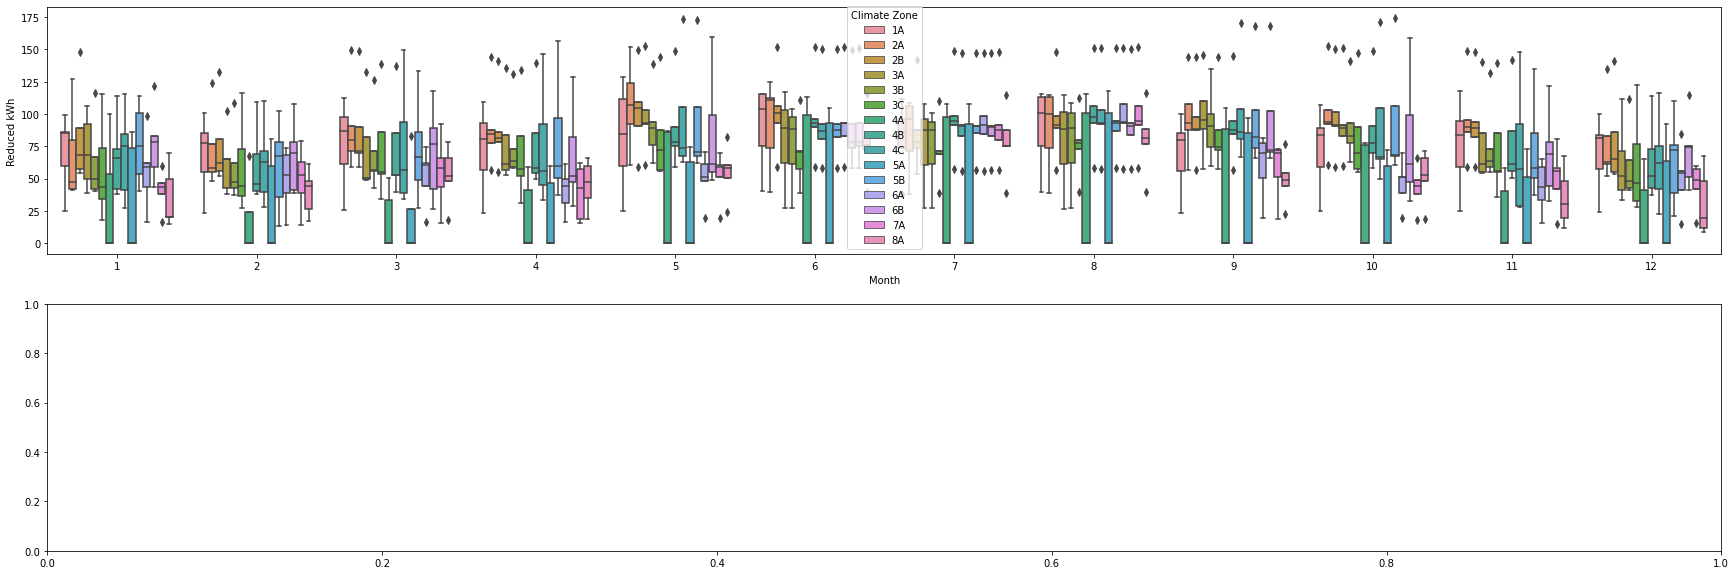

In [47]:
# df_all_kpis['Reduced kWh'].plot(kind='box')
# df_all_kpis['Rebound kWh'].plot(kind='box')
# df_all_kpis['Max kW Reduction'].plot(kind='box')
f, axs = plt.subplots(2, 1, figsize=(30, 10))
sns.boxplot(x="Month", y="Reduced kWh",
            hue="Climate Zone", 
            data=df_all_kpis, ax=axs[0])
